In [1]:
from conf import *
from ydata_profiling import ProfileReport
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from functools import wraps
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import KernelDensity
import contextily as cx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/opt/anaconda3/envs/recomm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading and preprocessing

In [2]:
#Set the path of the data rather than in local.
base= Path('.')
DATA_DIR = base / "data" / "clean"
DATA_DIR.mkdir(parents=True, exist_ok=True)
#The Airbnb data
DATA_URL = "https://orca.casa.ucl.ac.uk/~jreades/data/20250615-London-listings.csv.gz"
DATA_PATH = DATA_DIR / "20250615-London-listings.csv.gz"


In [3]:
#Wrap the download data function with the decorato, and
#download the Airbnb data.
def check_cache(f):
    @wraps(f)
    def wrapper(src, dest):
        dest = Path(dest)
        if dest.exists() and dest.is_file():
            print(f"{dest} found locally!")
            return dest
        else:
            print(f"{dest} not found, downloading!")
            return f(src, dest)
    return wrapper

@check_cache
def download_data(src, dest):
    dest = Path(dest)
    dest.parent.mkdir(parents=True, exist_ok=True)
    response = urlopen(src)
    with dest.open("wb") as f:
        f.write(response.read())
    print(f"Data written to {dest}!")
    return dest

def load_listings():
    local_path = download_data(DATA_URL, DATA_PATH)
    return pd.read_csv(local_path)

# print a few for test.
df = load_listings()
df.head()

data/clean/20250615-London-listings.csv.gz found locally!


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.74,4.62,4.72,NaN,t,11,11,0,0,0.51
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.25,4.54,4.42,NaN,t,11,11,0,0,0.22
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,4.52,4.36,4.38,NaN,t,11,11,0,0,0.43
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,4.61,4.50,4.47,NaN,t,11,11,0,0,0.30
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,NaN,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,4.74,4.37,4.59,NaN,t,11,11,0,0,0.35


In [4]:
#Set the path of spatial data
SPATIAL_DIR = base / 'data' / 'spatial'
SPATIAL_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
#make a function to download the spatial data
def download_spatial(src_url, filename):
    dest = SPATIAL_DIR / filename
    if dest.exists():
        print(f"{filename} found locally!")
        return dest
    
    print(f"Downloading {filename}...")
    response = urlopen(src_url)
    with open(dest, 'wb') as f:
        f.write(response.read())
    print(f"Saved to {dest}")
    
    return dest

#the url of every spatial data
RAW_URLS = {
    "boroughs": "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Boroughs.gpkg",
    "water": "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Water.gpkg",
    "greenspace": "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Greenspace.gpkg",
    "msoa": "https://orca.casa.ucl.ac.uk/~jreades/data/MSOA-2011.gpkg",
    "msoa_names": "https://houseofcommonslibrary.github.io/msoanames/MSOA-Names-1.20.csv",
}

In [6]:
# Download all spatial files defined in RAW_URLS
local_paths = {}  # store downloaded paths

for key, url in RAW_URLS.items():
    filename = url.split("/")[-1]  # extract file name from URL
    local_path = download_spatial(url, filename)
    local_paths[key] = local_path  # store for later use

Boroughs.gpkg found locally!
Water.gpkg found locally!
Greenspace.gpkg found locally!
MSOA-2011.gpkg found locally!
MSOA-Names-1.20.csv found locally!


In [7]:
#define every spatial data
boroughs = gpd.read_file(local_paths["boroughs"])
msoa_origin = gpd.read_file(local_paths["msoa"])
greenspace = gpd.read_file(local_paths["greenspace"])
msoa_names = pd.read_csv(local_paths["msoa_names"])
water= gpd.read_file(local_paths["water"])

Because the main analysis is based on price, property type, number of listings from the landlord, and number of bookable nights, we are doing some data cleaning on that.

In [8]:
#Here are some data cleaning of Airbnb data
#remove special character in price
df['price'] = (df['price'].astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .replace("", None)
        .astype(float)
    )

#remove invalid prices
df = df[df['price'] > 0].copy()

#keep valid availability range
df = df[df['availability_365'].between(0, 365)]

#drop listings without spatial coordinates
df = df.dropna(subset=['latitude', 'longitude'])
#fill missing host listing count
df['host_total_listings_count'] = df['host_total_listings_count'].fillna(1)
#because there are some extreme luxury house, may set a cap on price.
df = df[df['price'] < 2000] #2000 maybe a proper price cap..

In [9]:
#merge the msoa data and msoa names
msoa = msoa_origin.merge(
    msoa_names,
    left_on="MSOA11CD",
    right_on="msoa11cd",
    how="left"
)

In order to prepare for the future further analysis, transform the Airbnb data from df to gdf, check the crs, and then join with the msoa.

In [10]:
#Read info about the msoa
#msoa.head()
msoa.crs

<Projected CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [11]:
#Convert listings DataFrame to points
gdf_listings = gpd.GeoDataFrame(df,
                                geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
                                crs="EPSG:4326")

#find if need to reproject listings to match msoa crs
if msoa.crs is not None and gdf_listings.crs != msoa.crs:
    gdf_listings = gdf_listings.to_crs(msoa.crs)

gdf_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.62,4.72,NaN,t,11,11,0,0,0.51,POINT (537739.117 173423.255)
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.54,4.42,NaN,t,11,11,0,0,0.22,POINT (537705.727 173397.87)
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,4.36,4.38,NaN,t,11,11,0,0,0.43,POINT (537510.287 173476.053)
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,4.50,4.47,NaN,t,11,11,0,0,0.30,POINT (537486.78 173470.967)
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,NaN,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,4.37,4.59,NaN,t,11,11,0,0,0.35,POINT (537488.831 173446.54)


In [12]:
#show msoa columns
print(msoa.columns)

Index(['MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM',
       'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ',
       'geometry', 'msoa11cd', 'msoa11nm', 'msoa11nmw', 'msoa11hclnm',
       'msoa11hclnmw', 'Laname'],
      dtype='object')


In [13]:
#Keep only geometry and MSOA identifiers for the join
msoa_1 = msoa[['MSOA11CD', 'MSOA11NM', 'geometry']]

#left join them
listings_msoa = gpd.sjoin(gdf_listings,msoa_1,how='left',predicate='within')

listings_msoa.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right,MSOA11CD,MSOA11NM
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,t,11,11,0,0,0.51,POINT (537739.117 173423.255),654.0,E02000677,Lewisham 025
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,t,11,11,0,0,0.22,POINT (537705.727 173397.87),654.0,E02000677,Lewisham 025
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,t,11,11,0,0,0.43,POINT (537510.287 173476.053),649.0,E02000672,Lewisham 020
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,t,11,11,0,0,0.30,POINT (537486.78 173470.967),649.0,E02000672,Lewisham 020
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,NaN,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,t,11,11,0,0,0.35,POINT (537488.831 173446.54),649.0,E02000672,Lewisham 020


In [14]:
#Ensure availability_365 and price are numeric
listings_msoa['availability_365'] = pd.to_numeric(listings_msoa['availability_365'])
listings_msoa['price'] = pd.to_numeric(listings_msoa['price'])

In [15]:
#drop rows where MSOA11CD is missing (outside London polygons)
listings_msoa = listings_msoa.dropna(subset=['MSOA11CD'])

# 1.Is Airbnb “Out of Control” in London

To assess whether Airbnb in London is experiencing "over control", we may say some illegal renting or pricing may causing over control. 

In [16]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('1.1 90-days rule', "There is a 90 days regulation(also known as short-let regulation)(https://www.nestify.co.uk/article/90-day-rule/), Short-term rentals are permitted for a maximum of 90 days a year, exceeding this period requires a special permit.  so are the Airbnb hosts against this policy will be a perspect.")

##### # 1.1

>There is a 90 days regulation(also known as short-let regulation)(https://www.nestify.co.uk/article/90-day-rule/), Short-term rentals are permitted for a maximum of 90 days a year, exceeding this period requires a special permit.  so are the Airbnb hosts against this policy will be a perspect.


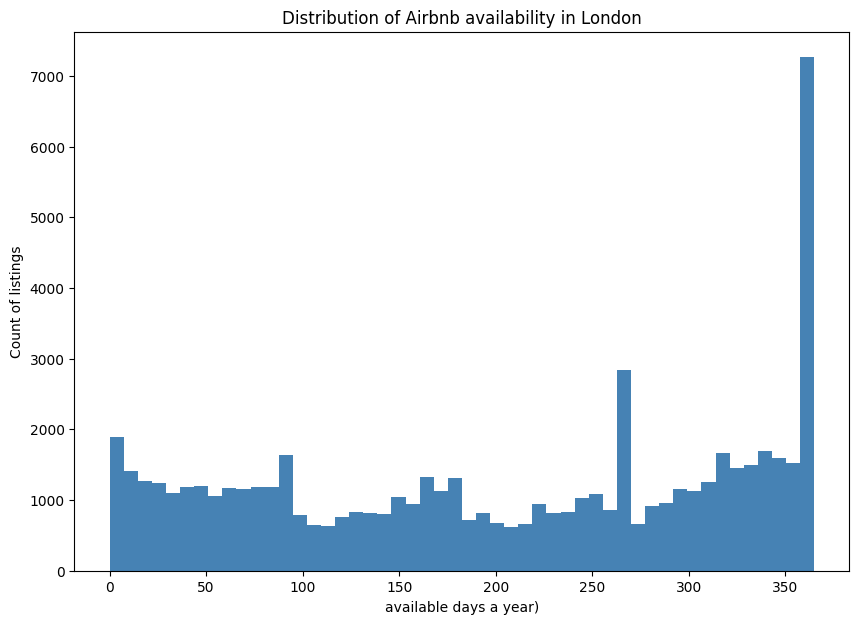

In [17]:
#The availability_365 distribution can indicate 
#whether Airbnb in London is a "seasonal short-term rental" 
#(low availability) or a "year-round operation" 
#(high availability).

# Plot distribution of availability_365
plt.figure(figsize=(10, 7))
plt.hist(df['availability_365'], bins=50, color='steelblue')
plt.xlabel("available days a year)")
plt.ylabel("Count of listings")
plt.title("Distribution of Airbnb availability in London")
plt.show()

In [18]:
#availability_365 > 90 is a potential key element
#of illegal hosting. 

#count the number of listing over 90, 180 and 300.
over_90 = (df['availability_365'] > 90)
over_180 = (df['availability_365'] > 180)
over_300 = (df['availability_365'] > 300)

print(f"Share of listings available > 90 days: {over_90.mean():.2%}")
print(f"Share of listings available > 180 days: {over_180.mean():.2%}")
print(f"Share of listings available > 300 days: {over_300.mean():.2%}")

Share of listings available > 90 days: 73.86%
Share of listings available > 180 days: 55.83%
Share of listings available > 300 days: 30.33%


In [19]:
# Compare availability patterns across room types
room_groups = df.groupby('room_type')['availability_365']

over_90_by_room = room_groups.apply(lambda x: (x > 90).mean())
print("Share of >90-day listings by room type:")
print((over_90_by_room * 100).round(2).astype(str) + "%")

Share of >90-day listings by room type:
room_type
Entire home/apt    73.72%
Hotel room         79.41%
Private room       74.01%
Shared room        87.21%
Name: availability_365, dtype: object


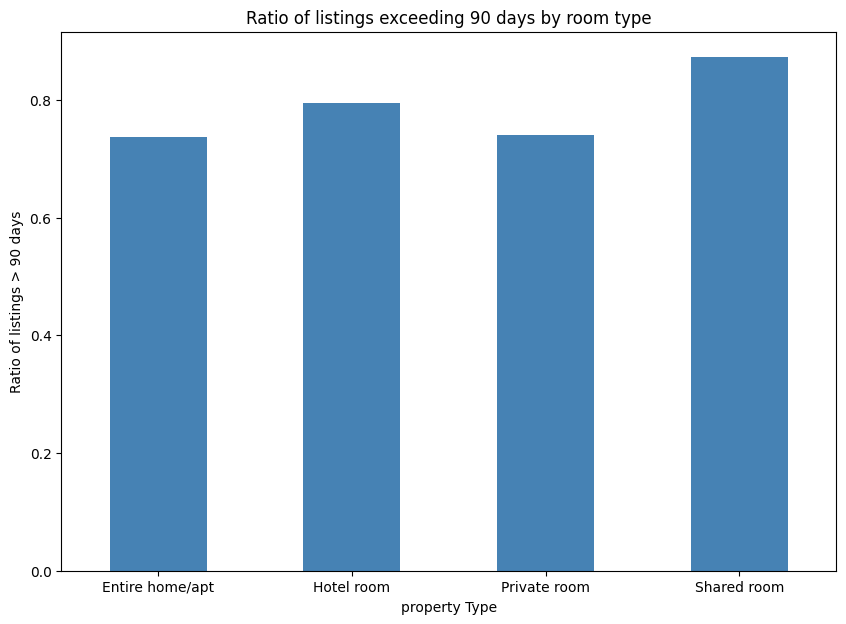

In [20]:
#plot ratio of property type >90
ax = over_90_by_room.plot(kind='bar', figsize=(10, 7), color='steelblue')
ax.set_xlabel("property Type")
ax.set_ylabel("Ratio of listings > 90 days")
ax.set_title("Ratio of listings exceeding 90 days by room type")
plt.xticks(rotation=0)
plt.show()

<Figure size 800x500 with 0 Axes>

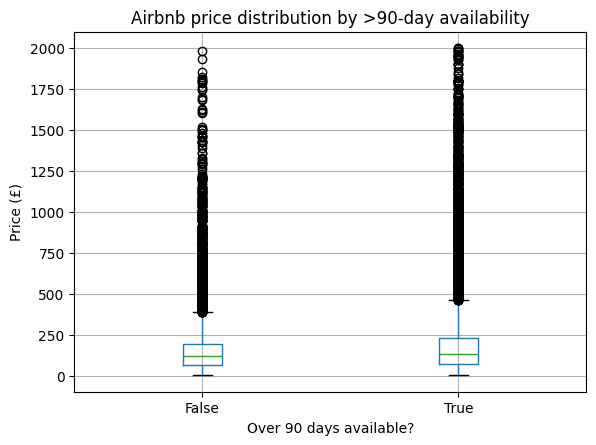

In [21]:
#Also can look at the price level of those over 90 days a year.
df['over_90'] = df['availability_365'] > 90

plt.figure(figsize=(8, 5))
df.boxplot(column='price', by='over_90')
plt.title("Airbnb price distribution by >90-day availability")
plt.suptitle("")
plt.xlabel("Over 90 days available?")
plt.ylabel("Price (£)")
plt.show()

In [22]:
as_markdown('1.2 Price level','Price level of Airbnb in London is another key aspect to indicate if airbnb out of control.')

##### #1.2

>Price level is another key aspect to indicate if airbnb out of control.


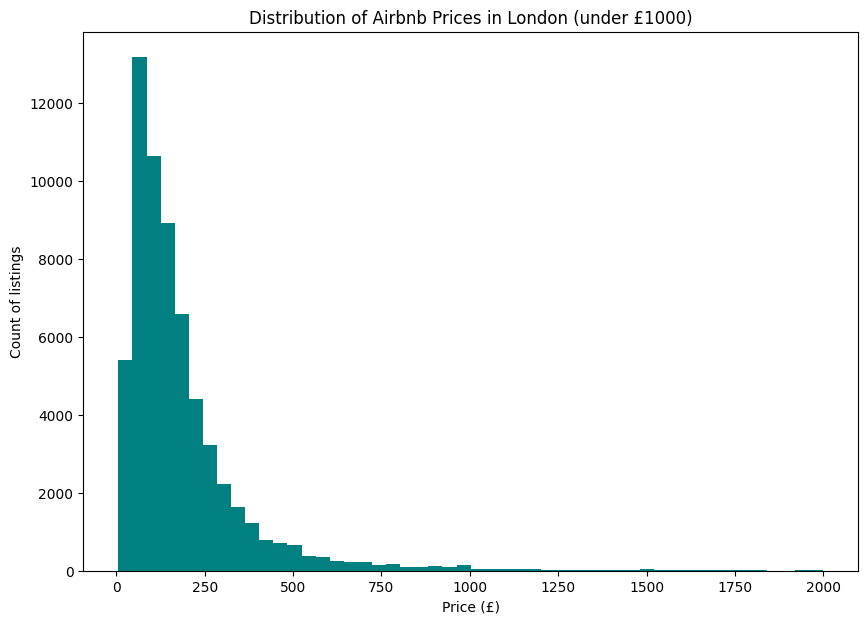

In [23]:
#Plot distribution of Airbnb prices
plt.figure(figsize=(10, 7))
plt.hist(df['price'], bins=50, color='teal')
plt.xlabel("Price (£)")
plt.ylabel("Count of listings")
plt.title("Distribution of Airbnb Prices in London (under £1000)")
plt.show()

In [24]:
#Look at some statistics on price
print("Price summary statistics:")
print(df['price'].describe())

Price summary statistics:
count    62445.000000
mean       185.369541
std        185.407696
min          6.000000
25%         75.000000
50%        134.000000
75%        224.000000
max       1999.000000
Name: price, dtype: float64


In [25]:
#We set a price level that ober 200 a night 
#could be "higher than usual", It may deviate from 
#Airbnb's original purpose.

high_price = df['price'] > 200
print(f"Share of listings priced > £200: {high_price.mean():.2%}")
#Shows price over 200 by room type.
high_price_by_type = df.groupby('room_type')['price'].apply(lambda x: (x > 200).mean())
print("\nShare of >£200 listings by room type:")
print((high_price_by_type * 100).round(2).astype(str) + "%")


Share of listings priced > £200: 29.38%

Share of >£200 listings by room type:
room_type
Entire home/apt    41.32%
Hotel room         41.18%
Private room        4.13%
Shared room         5.81%
Name: price, dtype: object


In [26]:
#Combine with the 90 days rule, count the ratio that
#satisfy over 200 a night and 90 a year.
df['over_90'] = df['availability_365'] > 90
df['high_price'] = df['price'] > 200
df['high_high'] = df['over_90'] & df['high_price']

print(f"Share of listings both >90 days and >£150: {df['high_high'].mean():.2%}")

Share of listings both >90 days and >£150: 22.91%


In [62]:
as_markdown("1.3 Kernel Density Estimation","In order to understand the spatial distribution pattern of Airbnb in London, we decided to use KDE to observe the overall trend of spatial intensity.")

##### 1.3 Kernel Density Estimation

>In order to understand the spatial distribution pattern of Airbnb in London, we decided to use KDE to observe the overall trend of spatial intensity.


In [28]:
#Firstly, aggregate listing data to the mosa level
listings_msoa['over_90'] = listings_msoa['availability_365'] > 90
msoa_stats_q1 = listings_msoa.groupby('MSOA11CD').agg(
    n_listings=('price', 'size'),#number of listing for every msoa
    ratio_over_90=('over_90', 'mean'),#ratio of listing >90 days
    mean_price=('price', 'mean')#mean price
).reset_index()

msoa_stats_q1.head()

,MSOA11CD,n_listings,ratio_over_90,mean_price
0,E02000001,430,0.848837,300.339535
1,E02000002,11,0.818182,140.818182
2,E02000003,28,0.892857,112.250000
3,E02000004,12,0.666667,115.750000
4,E02000005,13,0.923077,109.153846


In [29]:
#Convert listing points to EPSG:27700 for KDE
gdf_kde = gdf_listings.to_crs(epsg=27700)
#gdf_kde.head()

In [30]:
#extract coordinates for KDE
coords = np.vstack([gdf_kde.geometry.x,gdf_kde.geometry.y]).T#transpose the matrix for kde
#coords[:5]#show some of the matrix to check if success

In [31]:
#set a bandwidth to 750m in epsg27700
bandwidth = 750
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(coords)

,"bandwidth bandwidth: float or {""scott"", ""silverman""}, default=1.0The bandwidth of the kernel. If bandwidth is a float, it defines thebandwidth of the kernel. If bandwidth is a string, one of the estimationmethods is implemented.",750
,"algorithm algorithm: {'kd_tree', 'ball_tree', 'auto'}, default='auto'The tree algorithm to use.",'auto'
,"kernel kernel: {'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'}, default='gaussian'The kernel to use.",'gaussian'
,"metric metric: str, default='euclidean'Metric to use for distance computation. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.Not all metrics are valid with all algorithms: refer to thedocumentation of :class:`BallTree` and :class:`KDTree`. Note that thenormalization of the density output is correct only for the Euclideandistance metric.",'euclidean'
,"atol atol: float, default=0The desired absolute tolerance of the result. A larger tolerance willgenerally lead to faster execution.",0
,"rtol rtol: float, default=0The desired relative tolerance of the result. A larger tolerance willgenerally lead to faster execution.",0
,"breadth_first breadth_first: bool, default=TrueIf true (default), use a breadth-first approach to the problem.Otherwise use a depth-first approach.",True
,"leaf_size leaf_size: int, default=40Specify the leaf size of the underlying tree. See :class:`BallTree`or :class:`KDTree` for details.",40
,"metric_params metric_params: dict, default=NoneAdditional parameters to be passed to the tree for use with themetric. For more information, see the documentation of:class:`BallTree` or :class:`KDTree`.",None


In [32]:
# Create grid over bounding of London
x_min, y_min, x_max, y_max = gdf_kde.total_bounds
xgrid = np.linspace(x_min, x_max, 200)
ygrid = np.linspace(y_min, y_max, 200)
xx, yy = np.meshgrid(xgrid, ygrid)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

In [33]:
# Evaluate KDE on grid
z = np.exp(kde.score_samples(grid_points))
z = z.reshape(xx.shape)


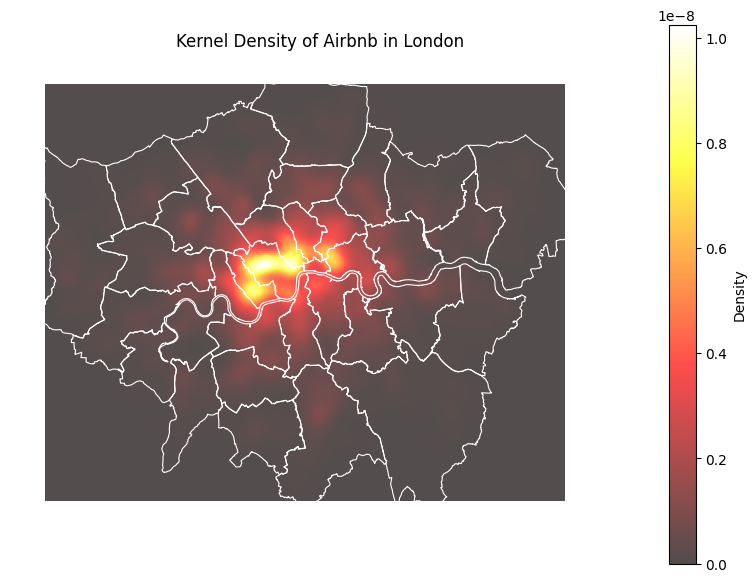

In [34]:
#plot the KDE
plt.figure(figsize=(10, 7))
plt.imshow(z,origin='lower',extent=(x_min, x_max, y_min, y_max),cmap='hot',alpha=0.7)#I think brighter is easier to see.

#Because only KDE is hard to analysis, we add London boundary onto it.
boroughs.to_crs(epsg=27700).boundary.plot(ax=plt.gca(),color='white',linewidth=0.8)

plt.title("Kernel Density of Airbnb in London")
plt.colorbar(label='Density')
plt.axis('off')
plt.show()


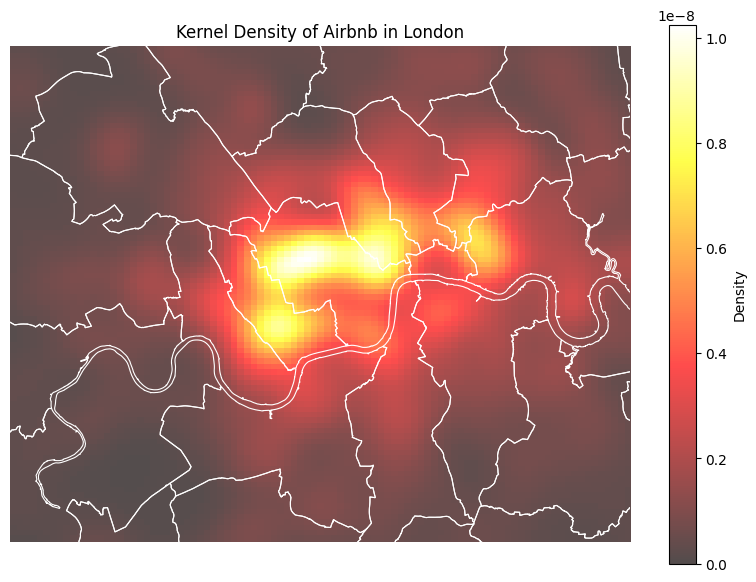

In [35]:
plt.figure(figsize=(10, 7))
plt.imshow(z,origin='lower',extent=(x_min, x_max, y_min, y_max),cmap='hot',alpha=0.7)
boroughs.to_crs(epsg=27700).boundary.plot(ax=plt.gca(),color='white',linewidth=0.8)
#Above code is same with the code in the upper chunk

#I zoom into the city centre this time
plt.xlim(515000, 540000)
plt.ylim(170000, 190000)


plt.title("Kernel Density of Airbnb in London")
plt.colorbar(label='Density')
plt.axis('off')
plt.show()


In [64]:
as_markdown("1.4 Hotpot Analysis","This demonstrates whether Airbnb's locations in London exhibit hotspot patterns. Clarify whether the out of control situation is regional rather than citywide.")

##### 1.4 Hotpot Analysis

>This demonstrates whether Airbnb's locations in London exhibit hotspot patterns. Clarify whether the out of control situation is regional rather than citywide.


In [37]:
gdf_la = gpd.sjoin(
    gdf_listings,
    boroughs[["NAME", "geometry"]],
    predicate="within",
    how="left"
)

# check it
gdf_la[["id", "NAME"]].head()

/var/folders/jn/5t3xdnln3szg1qhmjj7q89sw0000gn/T/ipykernel_49762/3828514820.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...
Right CRS: EPSG:27700

  gdf_la = gpd.sjoin(


,id,NAME
0,264776,Lewisham
1,264777,Lewisham
2,264778,Lewisham
3,264779,Lewisham
4,264780,Lewisham


In [38]:
borough_stats = (
    gdf_la.groupby('NAME')
          .agg(
              total_listings=('id', 'nunique'),
              multi_lister_share=(
                  'host_total_listings_count',
                  lambda x: (x > 2).mean()
              )
          )
          .sort_values('total_listings', ascending=False)
)

borough_stats

,total_listings,multi_lister_share
NAME,,
Westminster,8347,0.844136
Kensington and Chelsea,4697,0.802427
Camden,4473,0.779119
Tower Hamlets,4414,0.715904
Southwark,3211,0.609779
Hackney,3126,0.528471
Lambeth,2926,0.568353
Wandsworth,2901,0.526715
Islington,2737,0.633906


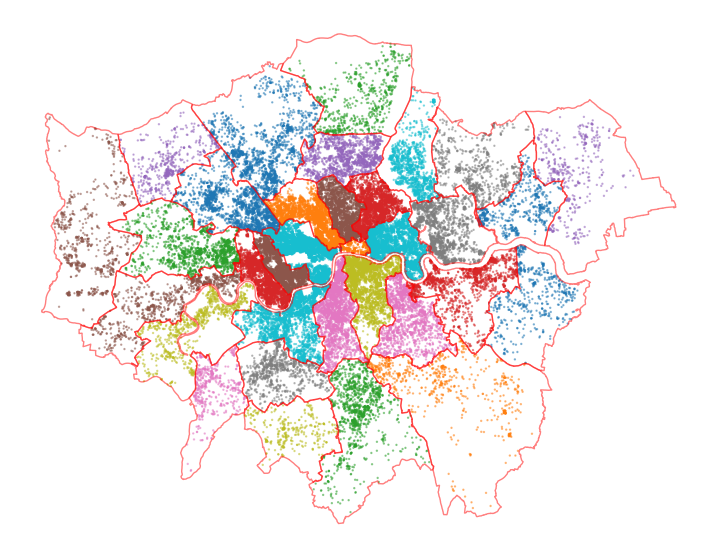

In [39]:
fig, ax = plt.subplots(figsize=(9,7))

# Click to color the name Borough
gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, ax=ax)

# Borough boundary
boroughs.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

ax.set_axis_off()
plt.show()

In [65]:
as_markdown("1.5 MSOA-Level Airbnb Activity in Westminster","")

##### 1.5 MSOA-Level Airbnb Activity in Westminster

>


Westminster polygon number: 1
The number of MSOA in Westminster: 41
The number of listings in Westminster: 8345

Example of MSOA statistics in Westminster：
    MSOA11CD                    MSOA11NM  listing_count
0  E02000124                   Brent 032              2
1  E02000126                   Brent 034              3
2  E02000191                  Camden 026              5
3  E02000193                  Camden 028              2
4  E02000588  Kensington and Chelsea 012              1


/var/folders/jn/5t3xdnln3szg1qhmjj7q89sw0000gn/T/ipykernel_49762/2589179527.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...
Right CRS: EPSG:27700

  msoa_west = gpd.clip(msoa, west_boro)


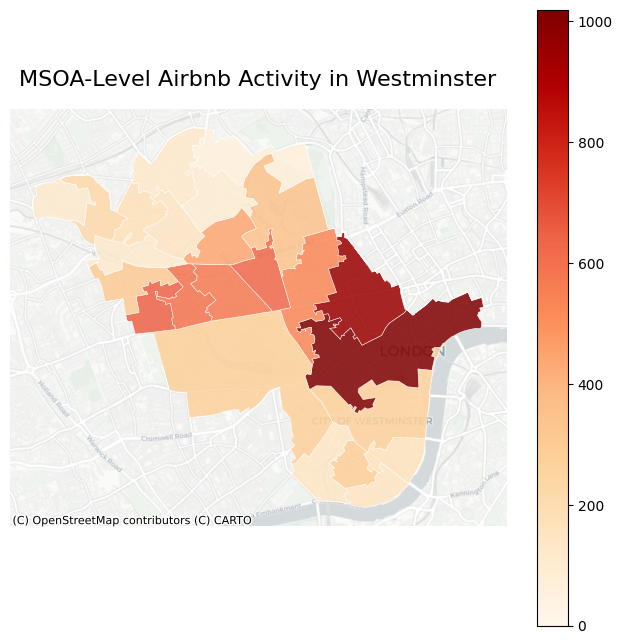

In [41]:
#Only take the Borough polygon from Westminster.
LA = "Westminster"
west_boro = boroughs[boroughs["NAME"] == LA].copy()
print("Westminster polygon number:", len(west_boro))

#Use Westminster polygon to crop MSOA (only keep MSOAs in Westminster).
msoa_west = gpd.clip(msoa, west_boro)
print("The number of MSOA in Westminster:", len(msoa_west))

pts_west_msoa = gpd.sjoin(
    gdf_listings,
    msoa_west[["MSOA11CD", "MSOA11NM", "geometry"]],
    predicate="within",
    how="inner"     # just need the spots in MSOA
)
print("The number of listings in Westminster:", len(pts_west_msoa))

#Statistics by MSOA: How many listings are there per MSOA?
msoa_stats = (
    pts_west_msoa
      .groupby(["MSOA11CD", "MSOA11NM"])
      .size()
      .reset_index(name="listing_count")
)
print("\nExample of MSOA statistics in Westminster：")
print(msoa_stats.head())

#Merge listing_count back into Westminster's MSOA polygon
msoa_west_counts = msoa_west.merge(
    msoa_stats,
    on=["MSOA11CD", "MSOA11NM"],
    how="left"
)

#For MSOA without a listing, enter 0.
msoa_west_counts["listing_count"] = msoa_west_counts["listing_count"].fillna(0)

#Convert to Web Mercator for overlaying background images
msoa_west_3857 = msoa_west_counts.to_crs(epsg=3857)

#plot：MSOA-Level Airbnb Activity in Westminster
fig, ax = plt.subplots(figsize=(8, 8))
msoa_west_3857.plot(
    column="listing_count",
    cmap="OrRd",
    linewidth=0.4,
    edgecolor="white",
    legend=True,
    ax=ax,
    alpha=0.85
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("MSOA-Level Airbnb Activity in Westminster", fontsize=16)
plt.show()

In [42]:
as_markdown("1.6 MSOA-level CLustering","To identify the spatial types of Airbnb activities in London, we selected three variables at the MSOA level to do clustering.")

##### 1.6 MSOA-level CLustering

>To identify the spatial types of Airbnb activities in London, we selected three variables at the MSOA level to do clustering.


In [43]:
#features for clustering
features = msoa_stats_q1[['ratio_over_90', 'n_listings', 'mean_price']].copy()
# Replace missing values with 0
features = features.fillna(0)
features.describe()


,ratio_over_90,n_listings,mean_price
count,982.000000,982.000000,982.000000
mean,0.763689,63.575356,135.155343
std,0.114638,91.021152,59.115535
min,0.428571,1.000000,35.666667
25%,0.682301,17.000000,98.985248
50%,0.756991,35.000000,121.850473
75%,0.834420,74.000000,158.881612
max,1.000000,1019.000000,573.697080


In [44]:
#Because there is a large difference between the value of those three variables, 
#we need to do a standardisation.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [46]:
#Use KMeans as the clustering method
kmeans = KMeans(n_clusters=3, random_state=42,n_init=10)#I choose 3 because it's not that large or small
clusters = kmeans.fit_predict(X_scaled)

msoa_stats_q1['cluster'] = clusters
msoa_stats_q1['cluster'].value_counts()

cluster
2    521
1    401
0     60
Name: count, dtype: int64

In [48]:
#Comparing mean value of cluster for those three variables.
cluster_profile = (msoa_stats_q1.groupby('cluster')[['ratio_over_90', 'n_listings', 'mean_price']].mean().round(3))

cluster_profile

,ratio_over_90,n_listings,mean_price
cluster,,,
0,0.755,327.000,279.299
1,0.871,26.928,110.251
2,0.682,61.445,137.724


In [51]:
#add a lable to cluster
cluster_labels = {
    0: "High Airbnb represent areas",
    1: "Moderate Airbnb activity areas",
    2: "Low Airbnb presence areas"
}

msoa_stats_q1['cluster_label'] = msoa_stats_q1['cluster'].map(cluster_labels)

In [56]:
#keep only geometry and identifier for mapping
msoa_min=msoa[['MSOA11CD','MSOA11NM','geometry']].copy()
#attach cluster labels to msoa
msoa_stats_q1['cluster']=clusters

In [60]:
type(msoa_1)

geopandas.geodataframe.GeoDataFrame

In [57]:
#merge cluster results back onto msoa polygon
msoa_ready=msoa_min.merge(msoa_stats_q1,on='MSOA11CD',how='left')

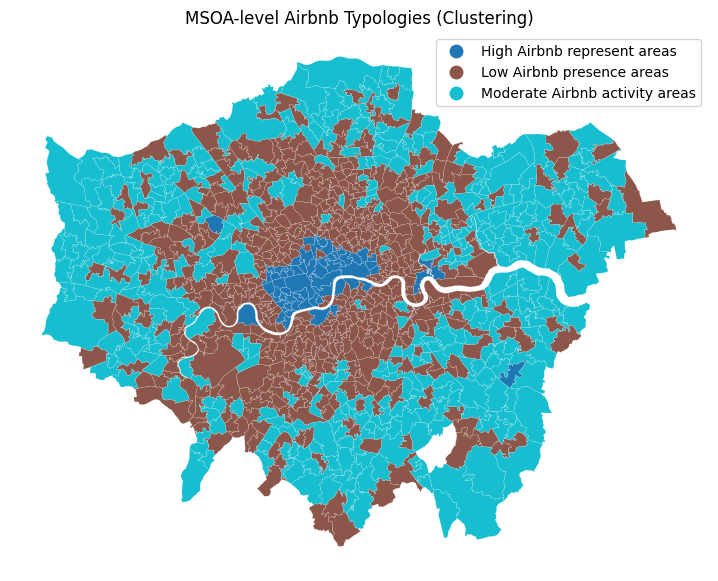

In [66]:
#Plot a graph of MSOA-level Airbnb area types based on clustering.
fig, ax = plt.subplots(figsize=(10,7))

msoa_ready.plot(
    column='cluster_label',
    categorical=True,
    legend=True,
    ax=ax,
    linewidth=0.1,
    edgecolor='white'
)

ax.set_axis_off()
ax.set_title("MSOA-level Airbnb Typologies (Clustering)")
plt.show()


# 2. How many professional landlords are there?
To assess whether Airbnb in London is experiencing "over control", we may say a host with multiple renting houses are over-commercialisation is causing over control. So start with analyzed the number of listings available from each host.

In [ ]:
#calculate proportion of hosts with more than 2 listings
host_counts = df['host_total_listings_count']
multiratio = (host_counts > 2).mean()
print(f"Ratio of hosts with >2 listings: {multiratio:.2%}")

#Define bin and labels（menas how houses many a host renting)
bins = [0, 1, 4, 9, 19, 49, 999]
labels = ["1", "2–4", "5–9", "10–19", "20–49", "50+"]

# Create categorical bin column
df['host_bin'] = pd.cut(host_counts, bins=bins, labels=labels)
# Compute the ratio of hosts
dist = (df['host_bin'].value_counts(normalize=True).sort_index())
#plot
ax = dist.plot(kind='bar', figsize=(10, 7))
ax.set_xlabel("Number of listings owned by host")
ax.set_ylabel("Proportion of hosts")
ax.set_title("Distribution of Airbnb listings owned by host")
plt.show()

In [ ]:
#proportion of hosts with > 2 listings
host_level = df.groupby('host_id')['host_total_listings_count'].max()
multi_host_share = (host_level > 2).mean()
print(f"Proportion of multi-lister hosts (>2 listings): {multi_host_share:.2%}")

#proportion of listings owned by multi-listers
listing_multi_share = (df['host_total_listings_count'] > 2).mean()
print(f"Proportion of listings owned by multi-listers: {listing_multi_share:.2%}")


In [ ]:
#Make a cumulative distribution
#compute cumulative ratio across host-size bins
cum = dist.cumsum()
#graph fitting
fig, ax1 = plt.subplots(figsize=(10, 7))
# Plot a same graph above
ax1.bar(dist.index, dist.values, label="Bin share")
ax1.set_xlabel("Number of listings owned by host")
ax1.set_ylabel("Proportion of hosts")
#Create another axis for cumulative line plot
ax2 = ax1.twinx()
ax2.plot(cum.index, cum.values, color="red", marker="o", label="Cumulative ratio")
ax2.set_ylabel("Cumulative ratio")
plt.show()
#Print cumulative ratio values
print("Cumulative share by bin:")
print((cum * 100).round(2).astype(str) + "%")


# 3.How many properties would be affected by the opposition’s proposal?

In [ ]:
#Find all professional landlords' host_id
pro_hosts = df[df['host_total_listings_count'] > 2]['host_id'].unique()
#Filter all listings under these landlords' names
affected_properties = df[df['host_id'].isin(pro_hosts)]
#Calculate the number of affected properties
n_affected = len(affected_properties)
#Compared to the entire Airbnb market
total_listings = len(df)
affected_ratio = n_affected / total_listings

n_affected, affected_ratio

In [ ]:
as_markdown("3.1","A bar chart showing the distribution of affected listings by region")

In [ ]:
affected_by_area = (
    affected_properties.groupby('neighbourhood_cleansed')
                       .size()
                       .reset_index(name='n_affected')
                       .sort_values('n_affected', ascending=False)
)

plt.figure(figsize=(10,6))
plt.bar(affected_by_area['neighbourhood_cleansed'], affected_by_area['n_affected'])
plt.xticks(rotation=90)
plt.ylabel('Number of Affected Listings')
plt.title('Affected Listings by Neighbourhood')
plt.show()

##Display the location of professional landlord listings on a map

In [ ]:
as_markdown("3.2","Display the location of professional landlord listings on a map")

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(df['longitude'], df['latitude'], s=2, alpha=0.1, label='All Listings')
plt.scatter(affected_properties['longitude'], affected_properties['latitude'], s=4, color='red', alpha=0.5, label='Affected Listings')

plt.legend()
plt.title('Spatial Distribution of Affected Listings (Professional Landlords)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()